In [7]:
import numpy as np
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, record,order
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt
import talib  

def normalization(df):
    for col in df.columns:
        array = np.asarray(np.asarray(df[col]))
        array = (array - array.min()) / (array.max() - array.min())
        df[col] = array
    return df

def initialize(context):
    # Which stocks to trade
    
    # url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    # tables = pd.read_html(url)
    # now_sp500_ticker = list(tables[0]['Symbol'])
    # all_historic_sp500 = list(set(now_sp500_ticker))
    # tickers = [str(ticker) for ticker in all_historic_sp500 if ticker != "nan"]
    # tickers = [ticker.replace('.', '-') for ticker in tickers]
    # tickers = sorted(tickers)
    tickers = ['AAPL', 'IBM', 'MSFT', 'AMZN']
    
    # Make symbol list from tickers
    lst = []
    for s in tickers:
        try:
            lst.append(symbol(s))
        except:
            continue
            
    context.universe = symbol('AAPL')
    # History window
    context.history_window = 21

    # Size of our portfolio
    context.stocks_to_hold = 3

    # Rebalance every month on the first trading day
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open())
    
    # Track positions
    context.positions = {}
    context.last_purchase_price = {}
    

def rebalance(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe,["close", "high", "low"], context.history_window, "1d")
    date_lst = hist.index

    atr = pd.DataFrame()
    rsi = pd.DataFrame()
    macd, macdsignal, macdhist = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for stock in context.universe:
        high_prices = hist[stock]['high']
        low_prices = hist[stock]['low']
        close_prices = hist[stock]['close']
        
        if len(close_prices) >= 30:
            atr[stock] = talib.ATR(np.asarray(high_prices), np.asarray(low_prices), np.asarray(close_prices), timeperiod=30)
            rsi[stock] = talib.RSI(np.asarray(close_prices), timeperiod=14)
            macd[stock],macdsignal[stock], macdhist[stock] = talib.MACD(np.asarray(close_prices), 12,26,9)
            
            atr = normalization(atr)[-1]
            print(atr)
            
            
        
        
                
        
        
def handle_data(context, data):
    record(leverage=context.account.leverage)
    # Check positions and manage them
    


# Set start and end date
start = pd.Timestamp(2000, 10, 1)
end = pd.Timestamp(2017, 12, 31)

# Fire off the backtest
result = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily',
    bundle='quandl'
)

# # Extract daily portfolio value
# returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)
# 
# # Create a PyFolio tear sheet
# pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)

C:\Users\jungh\AppData\Local\Programs\Python\Python312\Lib\site-packages\zipline\utils\events.py:486: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  .view(np.int64)
C:\Users\jungh\AppData\Local\Temp\tmpvqrmcddz\ipykernel_21208\4259236099.py:55: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  hist = data.history(context.universe,["close", "high", "low"], context.history_window, "1d")


TypeError: 'zipline.assets._assets.Equity' object is not iterable

In [2]:
%matplotlib inline

# Import Zipline functions that we need
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol,schedule_function, date_rules, time_rules

# Import date and time zone libraries
from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import talib

# Import visualization
import matplotlib.pyplot as plt

def normalization(array):
    array = (array - array.min()) / (array.max() - array.min())
    return array

def initialize(context):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    now_sp500_ticker = list(tables[0]['Symbol'])
    all_historic_sp500 = list(set(now_sp500_ticker))
    tickers = [str(ticker) for ticker in all_historic_sp500 if ticker != "nan"]
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    tickers = sorted(tickers)
    
    
    # Make symbol list from tickers
    lst = []
    for s in tickers:
        try:
            lst.append(symbol(s))
        except:
            continue
            
    context.universe = lst
    
    # Moving average window
    context.history_window = 60
    
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_close())
    
def rebalance(context, data):
    # Request history for the stock
    hist = data.history(context.universe,["close", "high", "low"], context.history_window, "1d")
    # date_lst = hist.index
    # atr = pd.DataFrame()
    # rsi = pd.DataFrame()
    # macd, macdsignal, macdhist = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    top_atr = 0
    print("*****")
    for stock in context.universe:
        high_prices = np.array(hist.loc[(slice(None), stock), 'high'].values,dtype=np.float64)
        low_prices = np.array(hist.loc[(slice(None), stock), 'low'].values,dtype=np.float64)
        close_prices = np.array(hist.loc[(slice(None), stock), 'close'].values,dtype=np.float64)

        print(high_prices)

        atr_series = talib.ATR(high_prices, low_prices, close_prices, timeperiod=14)
        rsi_series = talib.RSI(close_prices, timeperiod=14)
        macd_series, macdsignal_series, macdhist_series = talib.MACD(close_prices, 12, 26, 9)
        
        #print(atr_series)
        
        #Normalize the series if they are not None and not empty
        if atr is not None and len(atr_series) > 0:
            atr[stock] = normalization(atr)
            if atr[-1] > top_atr:
                top_atr = atr[-1]
                print(stock)
                
def handle_data(context):
    record(leverage=context.account.leverage)

def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', 
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], 
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)

# Set start and end date
start = pd.Timestamp(2016, 10, 1)
end = pd.Timestamp(2017, 12, 31)

# Fire off the backtest
results = run_algorithm(
    start=start, 
    end=end, 
    initialize=initialize, 
    analyze=analyze, 
    handle_data=handle_data, 
    capital_base=10000, 
    data_frequency = 'daily', bundle='quandl' 
) 

TypeError: handle_data() takes 1 positional argument but 2 were given

In [71]:
import warnings

# FutureWarning 무시
warnings.filterwarnings("ignore", category=FutureWarning)
# Import Zipline functions that we need
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, record, set_benchmark,order_value
import random

# Import date and time zone libraries
from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import talib
import pyfolio as pf
from datetime import datetime

# Import visualization
import matplotlib.pyplot as plt
import yfinance as yf

# Set start and end date
from exchange_calendars.calendar_helpers import parse_date,parse_timestamp
start = pd.Timestamp("2017-10-31 00:00:00")
end = pd.Timestamp("2017-12-31 00:00:00")


def print_array(array, array_name="Array"):
    print(f"--- {array_name} ---")
    print(array)
    print(f"Min: {array.min()}, Max: {array.max()}")
    print("---------------------")

def normalization(array, array_name="Array"):
    min_val = array.min()
    max_val = array.max()
    if min_val == max_val:
        print_array(array, array_name)
        raise ValueError(f"{array_name} has min and max values equal, normalization not possible.")
    array = (array - min_val) / (max_val - min_val)
    return array


def initialize(context):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    now_sp500_ticker = list(tables[0]['Symbol'])
    all_historic_sp500 = list(set(now_sp500_ticker))
    tickers = [str(ticker) for ticker in all_historic_sp500 if ticker != "nan"]
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    tickers = sorted(tickers)

    # Make symbol list from tickers
    lst = []
    for s in tickers:
        try:
            lst.append(symbol(s))
        except:
            continue

    context.universe = lst

    # Moving average window
    context.history_window = 60




def handle_data(context, data):
    
    print(context.datetime, context.portfolio)
    record(leverage=context.account.leverage)
    cash_amount = context.portfolio.cash

    # 현재 포트폴리오의 총 자산
    total_assets = context.portfolio.portfolio_value

    # 총 자산의 5%를 계산
    cash_allocation = int(0.05 * total_assets)

    # 현재 보유 현금을 총 자산의 5%로 나눈 몫
    cash_allocation_share = int(cash_amount // cash_allocation)

    if cash_allocation_share > 0:
        # Request history for the stock
        hist = data.history(context.universe, ["close", "high", "low"], context.history_window, "1d")
        # date_lst = hist.index
        atr_df = pd.DataFrame()
        rsi_df = pd.DataFrame()
        # macd, macdsignal, macdhist = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

        for stock in context.universe:
            high_prices = np.array(hist.loc[(slice(None), stock), 'high'].values, dtype=np.float64)
            low_prices = np.array(hist.loc[(slice(None), stock), 'low'].values, dtype=np.float64)
            close_prices = np.array(hist.loc[(slice(None), stock), 'close'].values, dtype=np.float64)

            atr = np.array(talib.ATR(high_prices, low_prices, close_prices, timeperiod=14))
            rsi = talib.RSI(close_prices, timeperiod=14)
            # macd, macdsignal, macdhist = talib.MACD(close_prices, 12, 26, 9)

            # Normalize the series if they are not None and not empty
            atr = atr[np.logical_not(np.isnan(atr))]
            rsi = rsi[np.logical_not(np.isnan(rsi))]

            if atr is not None and len(atr) > 14:
                normalized_atr = normalization(atr)
                temp_df = pd.DataFrame({stock: normalized_atr})
                atr_df = pd.concat([atr_df, temp_df], axis=1)

            if rsi is not None and len(atr) > 14:
                temp_df = pd.DataFrame({stock: rsi})
                rsi_df = pd.concat([rsi_df, temp_df], axis=1)

            else:
                pass

        last_3_days_data = atr_df.iloc[-3:]

        # Step 2: Calculate the mean for each column
        means = last_3_days_data.mean().nsmallest(cash_allocation_share).index
        
        monthly_buy_list = means
        print(len(monthly_buy_list))
        if len(monthly_buy_list) != 0:
            buy_value = (cash_amount / len(list(monthly_buy_list)))
            for buy_stock in monthly_buy_list:
                if data.can_trade(buy_stock) and not buy_stock in list(context.portfolio.positions.keys()):
                    if rsi_df[buy_stock].iloc[-1] > 70: 
                        if cash_allocation_share > 0:
                            order_target_percent(buy_stock, buy_value/context.portfolio.portfolio_value)

    for stock in context.portfolio.positions:
        position = context.portfolio.positions[stock]
        cost_basis = position.cost_basis

        current_price = data.current(stock, 'price')
        percent_change = (current_price - cost_basis) / cost_basis * 100

        current_position = context.portfolio.positions[stock].amount

        # 손실이 2% 이상 발생하면 청산
        global profit_cut
        global loss_cut
        
        profit_cut = 10
        loss_cut = -2
        
        if percent_change < loss_cut:
            order_target_percent(stock, 0)

        # 수익이 4% 이상 발생하면 청산
        elif percent_change > profit_cut:
            order_target_percent(stock, 0)


def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))

    # First chart
    ax = fig.add_subplot(311)
    ax.set_title(f'Strategy Results{start} to {end}, long: {profit_cut},short: {loss_cut},momentom, equal weight')
    ax.semilogy(perf['portfolio_value'], linestyle='-',
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)

    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'],
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)
    plt.show()




# Fire off the backtest
results = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily', bundle='quandl'
)

# Extract daily portfolio value
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# Create a PyFolio tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

2017-10-31 20:00:00+00:00 Portfolio({'cash_flow': 0.0, 'starting_cash': 10000, 'portfolio_value': 10000.0, 'pnl': 0.0, 'returns': 0.0, 'cash': 10000.0, 'positions': {}, 'start_date': Timestamp('2017-10-31 00:00:00'), 'positions_value': 0.0, 'positions_exposure': 0.0})
20
2017-11-01 20:00:00+00:00 Portfolio({'cash_flow': -442.46512, 'starting_cash': 10000, 'portfolio_value': 9999.774879999999, 'pnl': -0.22512000000097032, 'returns': -2.2512000000141086e-05, 'cash': 9557.53488, 'positions': {Equity(2878 [TTWO]): Position({'asset': Equity(2878 [TTWO]), 'amount': 4, 'cost_basis': 110.61628, 'last_sale_price': 110.56, 'last_sale_date': Timestamp('2017-11-01 20:00:00+0000', tz='UTC')})}, 'start_date': Timestamp('2017-10-31 00:00:00'), 'positions_value': 442.24, 'positions_exposure': 442.24})
19
2017-11-02 20:00:00+00:00 Portfolio({'cash_flow': -1156.6780450000003, 'starting_cash': 10000, 'portfolio_value': 9991.171955000002, 'pnl': -8.828044999998383, 'returns': -0.0008828044999998896, 'cash

KeyboardInterrupt: 

10000.0
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8159.964454999999
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895
8208.94895


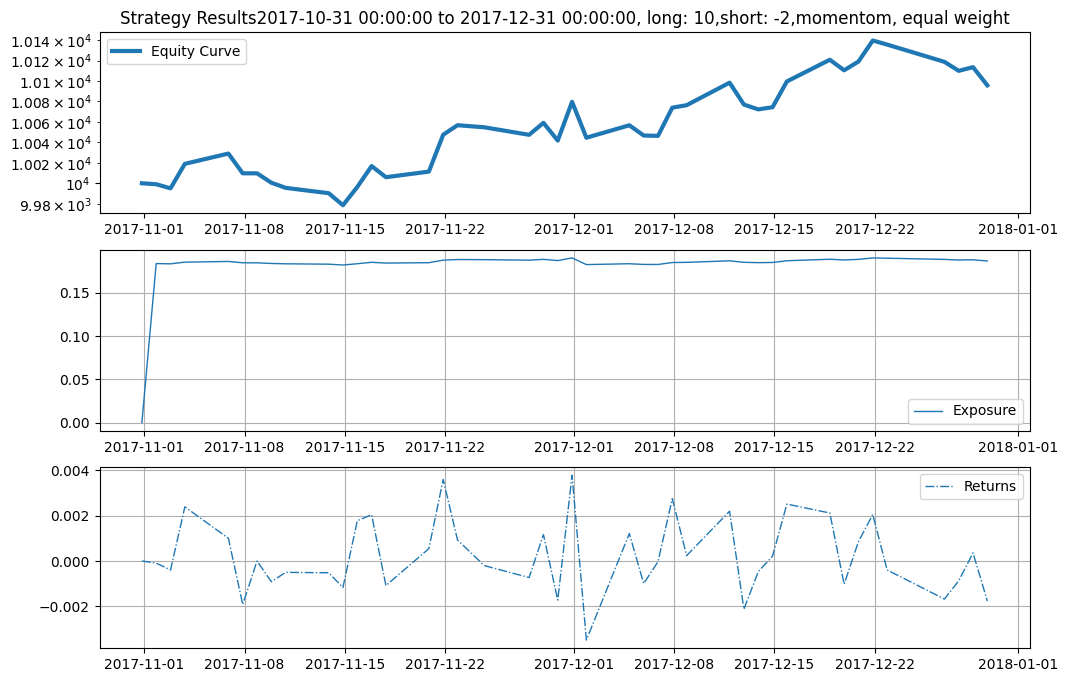

Start date,2017-10-31
End date,2017-12-29
Total months,2
,Backtest
Annual return,5.881%
Cumulative returns,0.957%
Annual volatility,2.579%
Sharpe ratio,2.23
Calmar ratio,11.74
Stability,0.85
Max drawdown,-0.501%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.50,2017-11-06,2017-11-14,2017-11-21,12
1,0.43,2017-12-21,2017-12-29,NaT,NaN
2,0.35,2017-11-30,2017-12-01,2017-12-11,8
3,0.26,2017-12-11,2017-12-13,2017-12-15,5
4,0.17,2017-11-28,2017-11-29,2017-11-30,3


C:\Users\jungh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
New Normal,0.02%,-0.35%,0.38%


Top 10 long positions of all time,max
sid,
AAL,10.52%
AAPL,8.79%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
AAL,10.52%
AAPL,8.79%


Start date,2017-10-31
End date,2017-12-29
Total months,2
,Backtest
Annual return,5.881%
Cumulative returns,0.957%
Annual volatility,2.579%
Sharpe ratio,2.23
Calmar ratio,11.74
Stability,0.85
Max drawdown,-0.501%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.50,2017-11-06,2017-11-14,2017-11-21,12
1,0.43,2017-12-21,2017-12-29,NaT,NaN
2,0.35,2017-11-30,2017-12-01,2017-12-11,8
3,0.26,2017-12-11,2017-12-13,2017-12-15,5
4,0.17,2017-11-28,2017-11-29,2017-11-30,3


C:\Users\jungh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


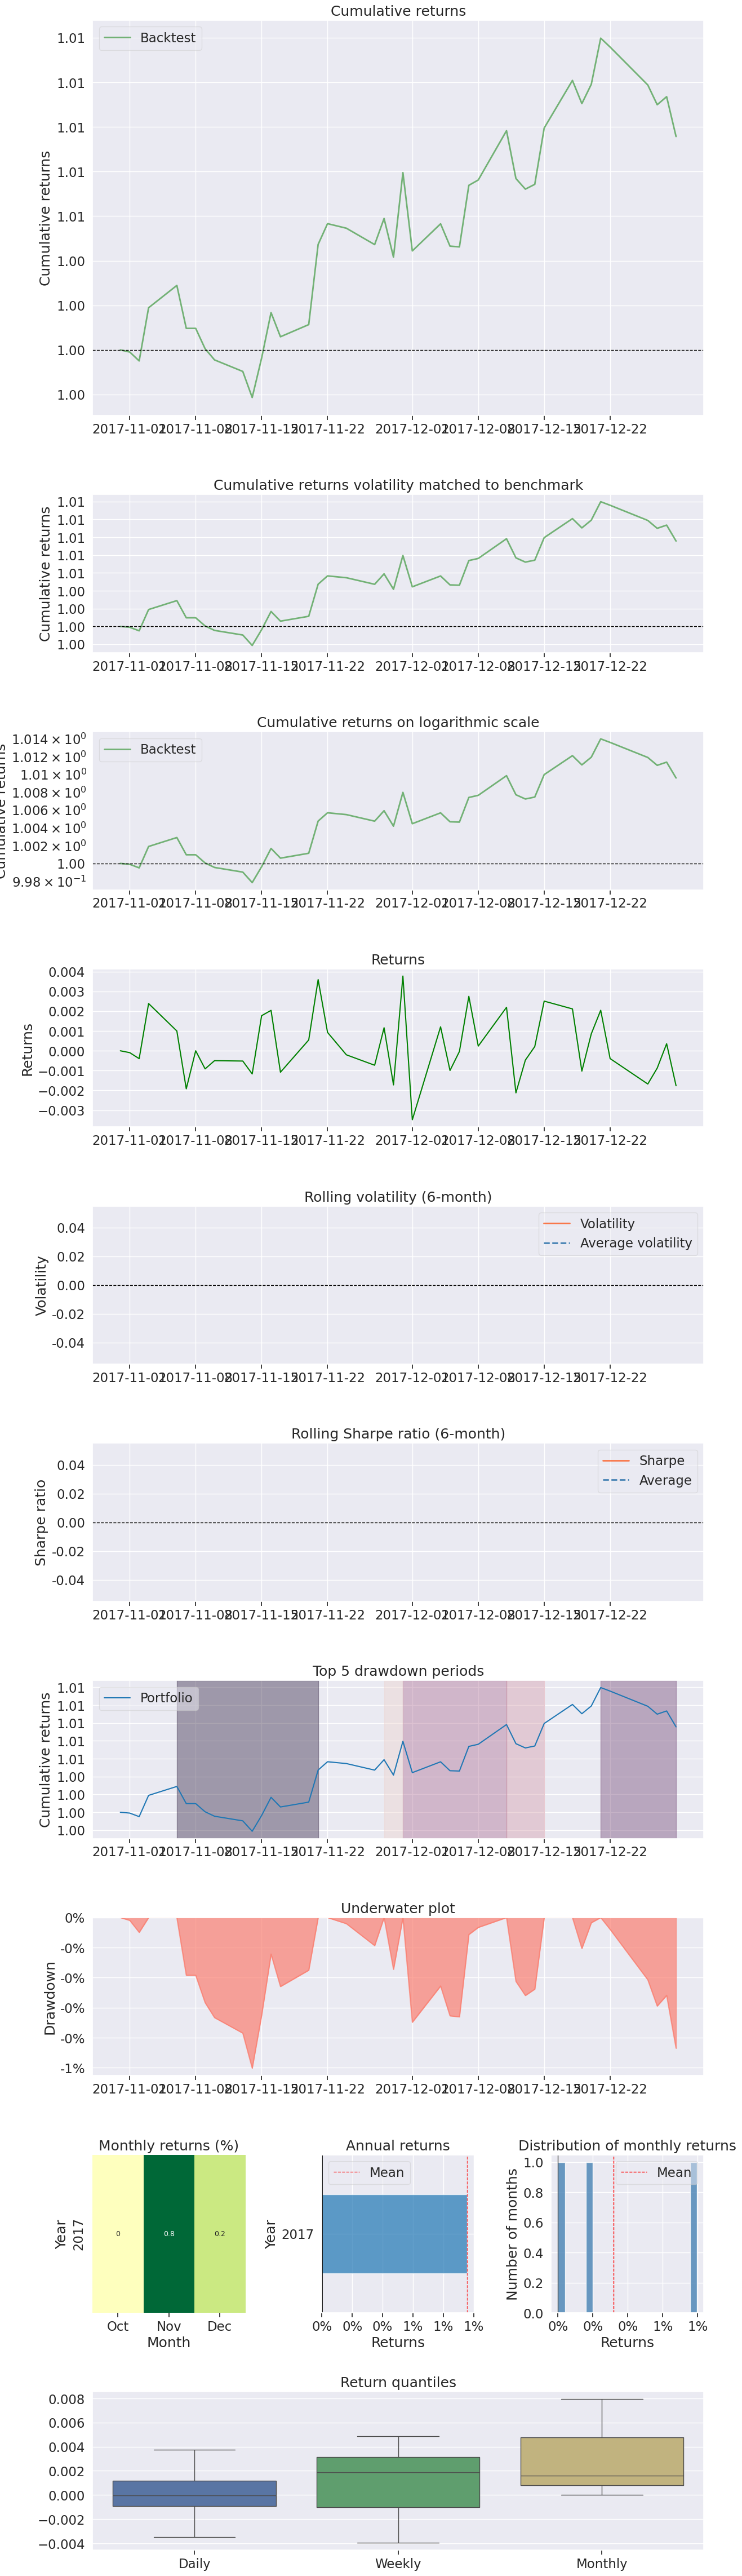

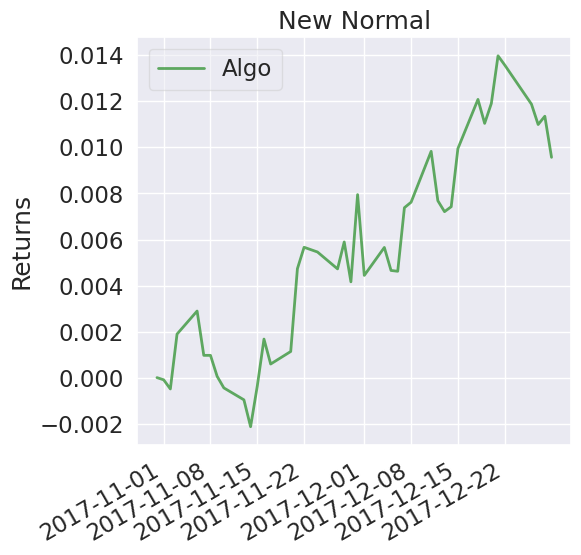

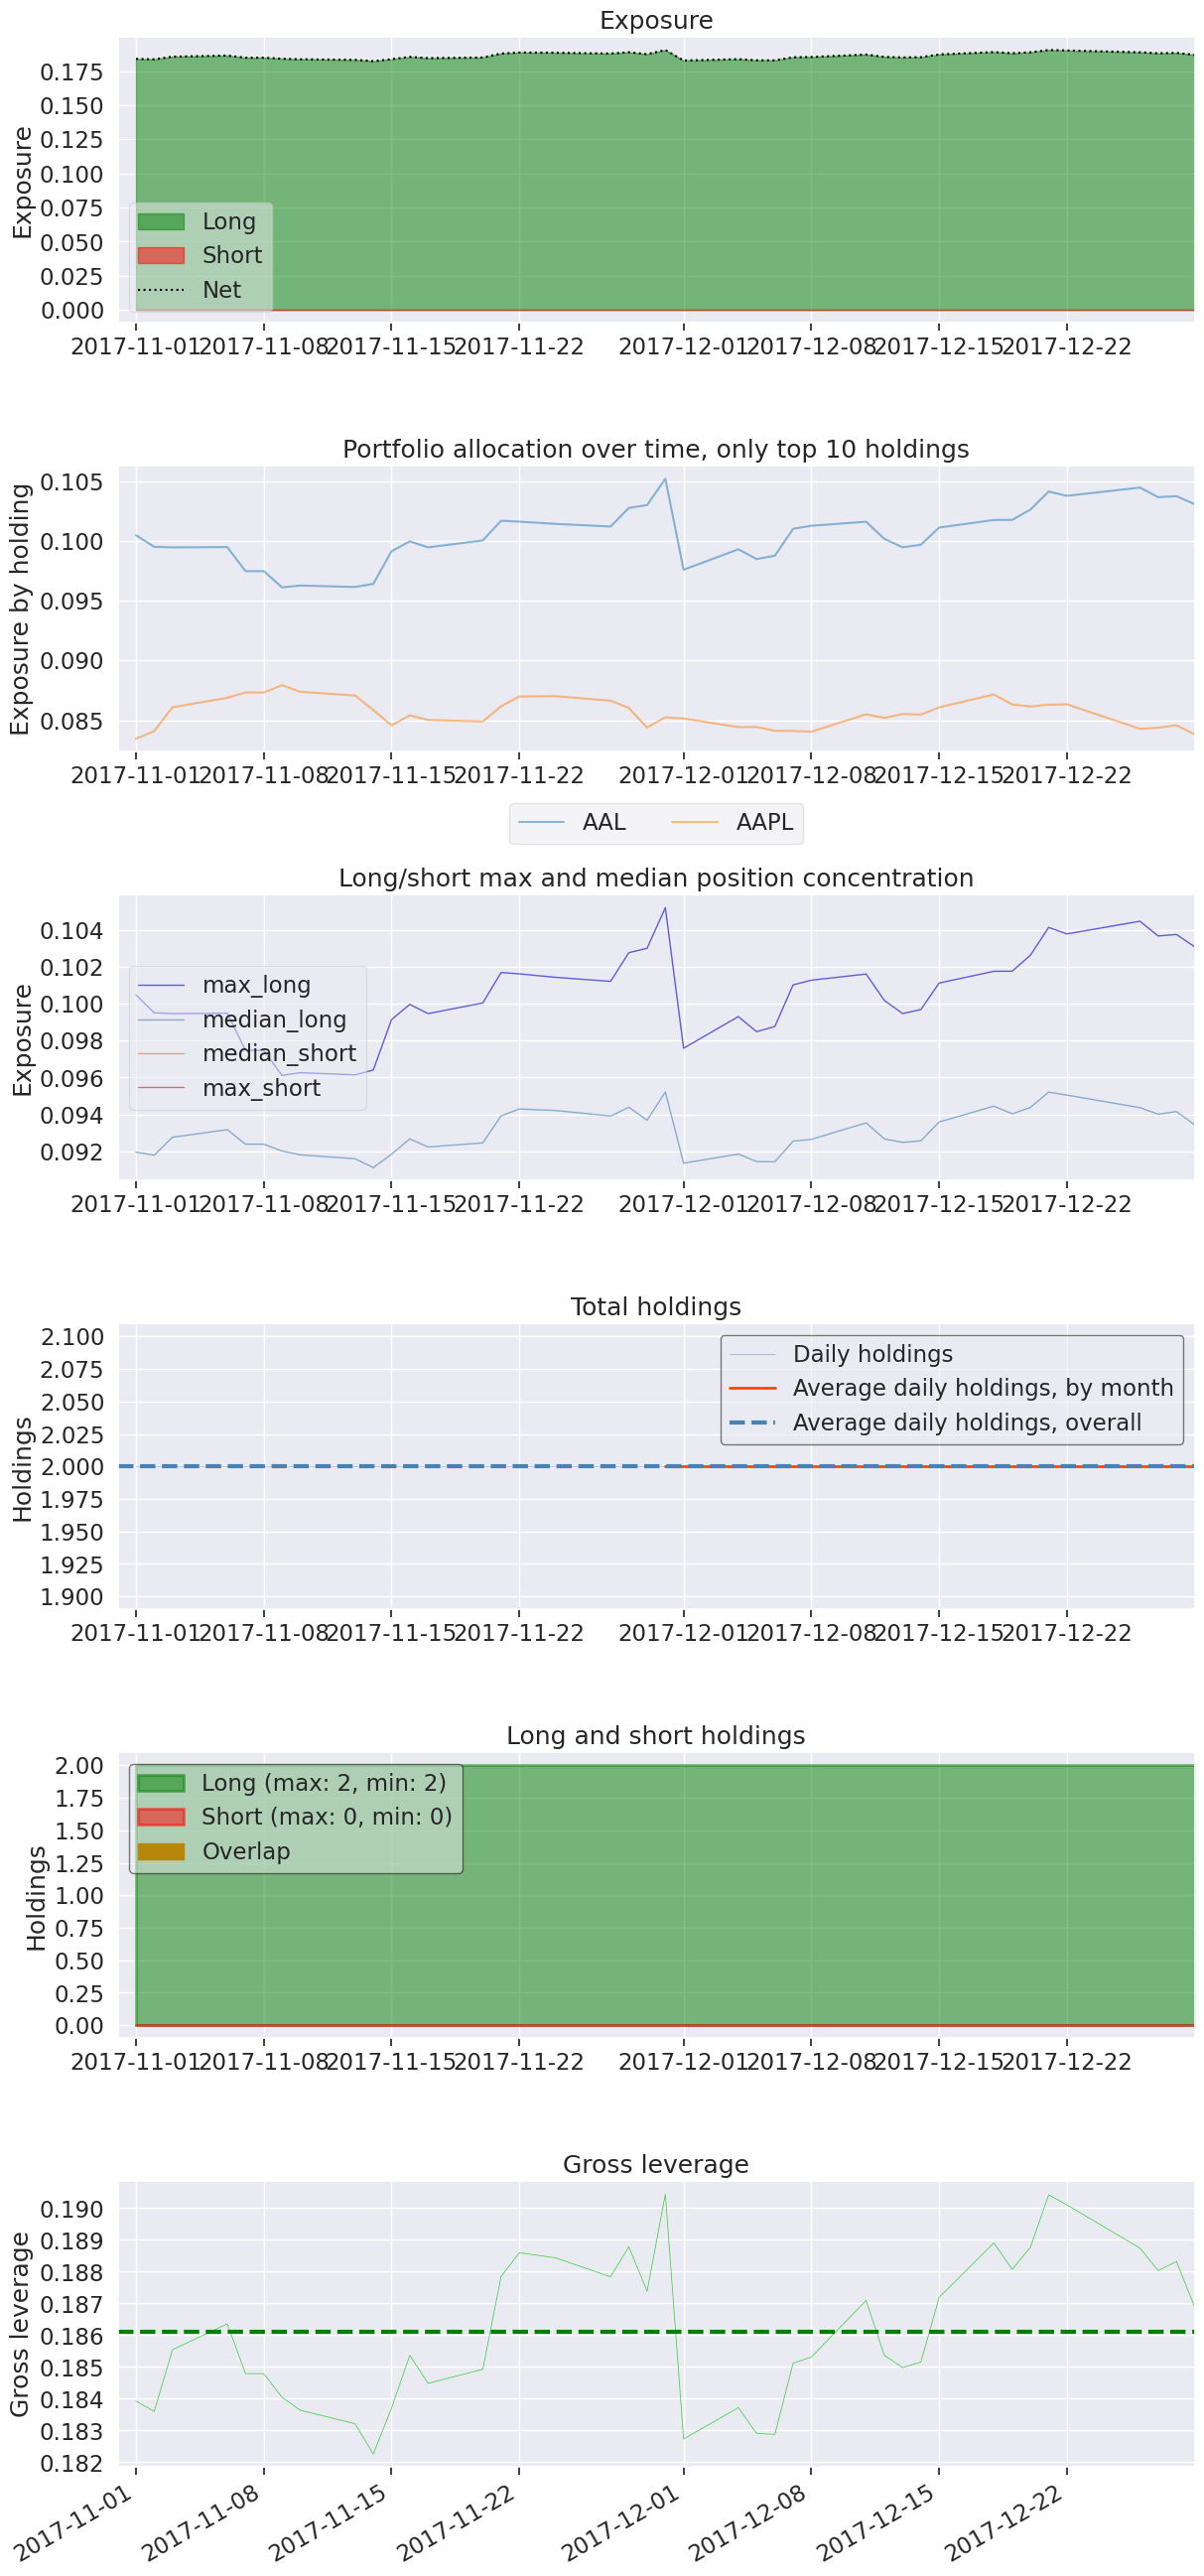

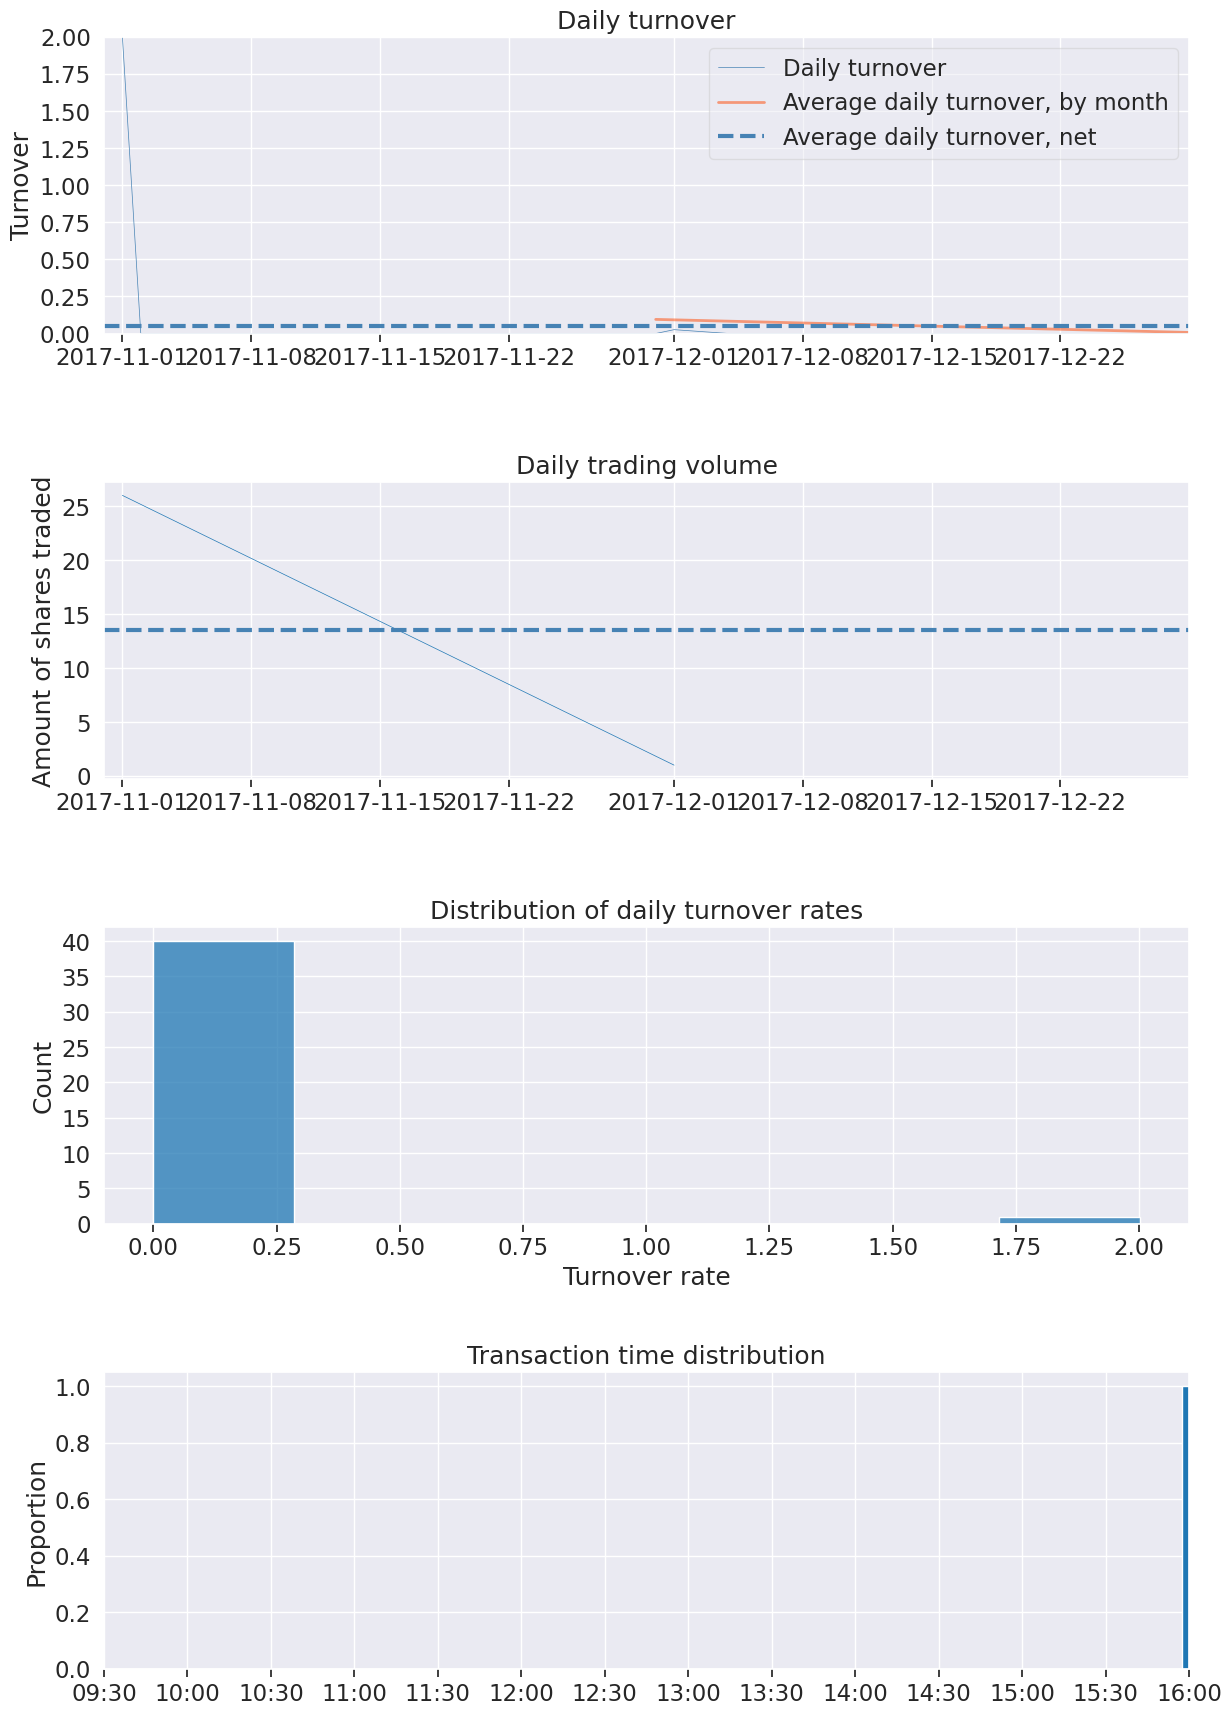

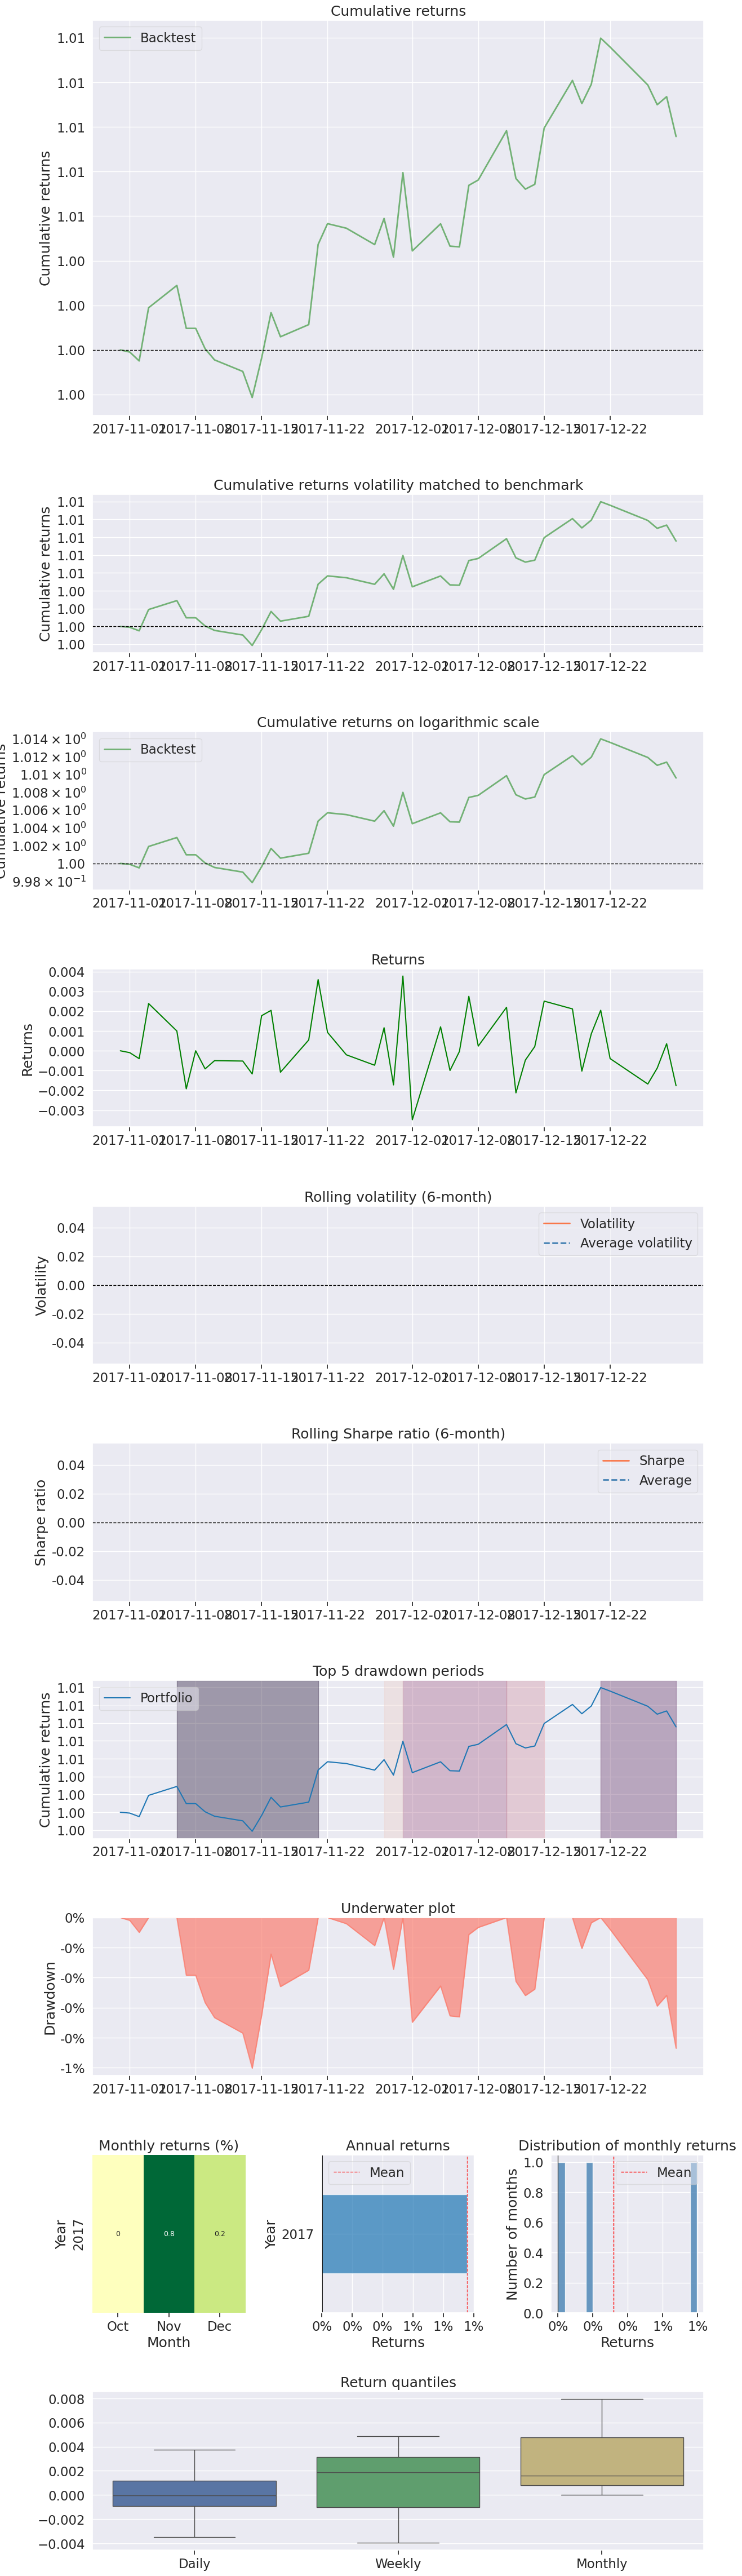

In [67]:
import warnings

# FutureWarning 무시
warnings.filterwarnings("ignore", category=FutureWarning)
# Import Zipline functions that we need
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, record, set_benchmark,order_value

# Import date and time zone libraries
from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import talib
import pyfolio as pf
from datetime import datetime

# Import visualization
import matplotlib.pyplot as plt
import yfinance as yf

# Set start and end date
from exchange_calendars.calendar_helpers import parse_date,parse_timestamp
start = pd.Timestamp("2017-10-31 00:00:00")
end = pd.Timestamp("2017-12-31 00:00:00")


def print_array(array, array_name="Array"):
    print(f"--- {array_name} ---")
    print(array)
    print(f"Min: {array.min()}, Max: {array.max()}")
    print("---------------------")

def normalization(array, array_name="Array"):
    min_val = array.min()
    max_val = array.max()
    if min_val == max_val:
        print_array(array, array_name)
        raise ValueError(f"{array_name} has min and max values equal, normalization not possible.")
    array = (array - min_val) / (max_val - min_val)
    return array


def initialize(context):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    now_sp500_ticker = list(tables[0]['Symbol'])
    all_historic_sp500 = list(set(now_sp500_ticker))
    tickers = [str(ticker) for ticker in all_historic_sp500 if ticker != "nan"]
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    tickers = sorted(tickers)

    # Make symbol list from tickers
    lst = []
    for s in tickers:
        try:
            lst.append(symbol(s))
        except:
            continue

    context.universe = lst

    # Moving average window
    context.history_window = 60




def handle_data(context, data):
    
    #print(context.datetime, context.portfolio)
    record(leverage=context.account.leverage)
    cash_amount = context.portfolio.cash
    
    order_target_percent(context.universe[0],0.1)
    order_target_percent(context.universe[1],0.1)
    print(cash_amount)

def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))

    # First chart
    ax = fig.add_subplot(311)
    ax.set_title(f'Strategy Results{start} to {end}, long: {profit_cut},short: {loss_cut},momentom, equal weight')
    ax.semilogy(perf['portfolio_value'], linestyle='-',
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)

    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'],
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)
    plt.show()




# Fire off the backtest
results = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily', bundle='quandl'
)

# Extract daily portfolio value
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# Create a PyFolio tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

In [ ]:
import warnings

# FutureWarning 무시
warnings.filterwarnings("ignore", category=FutureWarning)
# Import Zipline functions that we need
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, record, set_benchmark,order_value
import random

# Import date and time zone libraries
from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import talib
import pyfolio as pf

# Import visualization
import matplotlib.pyplot as plt
import yfinance as yf

# Set start and end date
start = pd.Timestamp(2000, 1, 9)
end = pd.Timestamp(2017, 10, 13)



def print_array(array, array_name="Array"):
    print(f"--- {array_name} ---")
    print(array)
    print(f"Min: {array.min()}, Max: {array.max()}")
    print("---------------------")

def normalization(array, array_name="Array"):
    min_val = array.min()
    max_val = array.max()
    if min_val == max_val:
        print_array(array, array_name)
        raise ValueError(f"{array_name} has min and max values equal, normalization not possible.")
    array = (array - min_val) / (max_val - min_val)
    return array

def buy_list(rsi_df, atr_df, cash_allocation_share):
    # Check if rsi_df is not empty and has at least one row
    if rsi_df.empty or len(rsi_df) < 1:
        return []

    # Step 1: Get tickers where RSI is greater than 70
    select_ticker = rsi_df.iloc[-1][rsi_df.iloc[-1] > 70].index
    
    # Check if select_ticker is not empty
    if len(select_ticker) == 0:
        print("NONO")
        return []

    # Step 2: Filter the last 3 days data for these tickers from ATR DataFrame
    last_3_days_data = atr_df[select_ticker].iloc[-3:]

    # Step 3: Calculate the mean ATR for each selected ticker
    mean_atr = last_3_days_data.mean().nsmallest(cash_allocation_share).index
    

    # Step 4: Create the final buy list
    monthly_buy_list = list(mean_atr)
    
    if len(monthly_buy_list) > 0:
        return monthly_buy_list
    else:
        return []


def initialize(context):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    now_sp500_ticker = list(tables[0]['Symbol'])
    all_historic_sp500 = list(set(now_sp500_ticker))
    tickers = [str(ticker) for ticker in all_historic_sp500 if ticker != "nan"]
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    tickers = sorted(tickers)

    # Make symbol list from tickers
    lst = []
    for s in tickers:
        try:
            lst.append(symbol(s))
        except:
            continue

    context.universe = lst

    # Moving average window
    context.history_window = 60




def handle_data(context, data):
    
    print(context.datetime, context.portfolio.cash)
    record(leverage=context.account.leverage)
    cash_amount = context.portfolio.cash
    
    # 현재 포트폴리오의 총 자산
    total_assets = context.portfolio.portfolio_value
    # 총 자산의 5%를 계산
    cash_allocation = int(0.05 * total_assets)
    
    if cash_amount // cash_allocation > 0:
        # 현재 보유 현금을 총 자산의 5%로 나눈 몫
        cash_allocation_share = int(cash_amount // cash_allocation)
        print(f"can buy: {cash_allocation_share}")
        
        if cash_allocation_share > 0:
            # Request history for the stock
            hist = data.history(context.universe, ["close", "high", "low"], context.history_window, "1d")
            # date_lst = hist.index
            atr_df = pd.DataFrame()
            rsi_df = pd.DataFrame()
            # macd, macdsignal, macdhist = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    
            for stock in context.universe:
                high_prices = np.array(hist.loc[(slice(None), stock), 'high'].values, dtype=np.float64)
                low_prices = np.array(hist.loc[(slice(None), stock), 'low'].values, dtype=np.float64)
                close_prices = np.array(hist.loc[(slice(None), stock), 'close'].values, dtype=np.float64)
    
                atr = np.array(talib.ATR(high_prices, low_prices, close_prices, timeperiod=14))
                rsi = talib.RSI(close_prices, timeperiod=14)
                # macd, macdsignal, macdhist = talib.MACD(close_prices, 12, 26, 9)
    
                # Normalize the series if they are not None and not empty
                atr = atr[np.logical_not(np.isnan(atr))]
                rsi = rsi[np.logical_not(np.isnan(rsi))]
    
                if atr is not None and len(atr) > 14:
                    normalized_atr = normalization(atr)
                    temp_df = pd.DataFrame({stock: normalized_atr})
                    atr_df = pd.concat([atr_df, temp_df], axis=1)
    
                if rsi is not None and len(atr) > 14:
                    temp_df = pd.DataFrame({stock: rsi})
                    rsi_df = pd.concat([rsi_df, temp_df], axis=1)
    
                else:
                    pass
            
            monthly_buy_list = buy_list(rsi_df,atr_df,cash_allocation_share)
            print(f"--------{len(monthly_buy_list)}-------{cash_allocation_share}")
            if len(monthly_buy_list) > 0:
                buy_value = (cash_amount / len(monthly_buy_list))
                for buy_stock in monthly_buy_list:
                    if data.can_trade(buy_stock) and not buy_stock in list(context.portfolio.positions.keys()):
                        if rsi_df[buy_stock].iloc[-1] > 70:
                            order_target_percent(buy_stock,0.05)
                            print(f"buy: {buy_stock}, num: {buy_value}")
            else:
                print("No positions found")
        elif cash_amount // cash_allocation == 0:
            print("portfolio is full")

    for stock in context.portfolio.positions:
        print(f"sell: {stock}")
        position = context.portfolio.positions[stock]
        cost_basis = position.cost_basis

        current_price = data.current(stock, 'price')
        percent_change = (current_price - cost_basis) / cost_basis * 100

        current_position = context.portfolio.positions[stock].amount

        # 손실이 2% 이상 발생하면 청산
        global profit_cut
        global loss_cut
        
        profit_cut = 15
        loss_cut = -3
        
        if percent_change < loss_cut:
            order_target_percent(stock, 0)

        # 수익이 4% 이상 발생하면 청산
        elif percent_change > profit_cut:
            order_target_percent(stock, 0)


def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))

    # First chart
    ax = fig.add_subplot(311)
    ax.set_title(f'Strategy Results{start} to {end}, long: {profit_cut},short: {loss_cut},momentom, equal weight')
    ax.semilogy(perf['portfolio_value'], linestyle='-',
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)

    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'],
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)
    plt.show()




# Fire off the backtest
results = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=100000,
    data_frequency='daily', bundle='quandl'
)

# Extract daily portfolio value
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

import yfinance as yf
one_day_before_start = start - pd.Timedelta(days=1)
sp500 = yf.download('^GSPC',one_day_before_start,end)['Adj Close']
# Download S&P 500 data from Yahoo Finance
sp500_returns = sp500.pct_change()

# Create a PyFolio tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)
pf.create_returns_tear_sheet(returns, benchmark_rets=sp500)

2000-01-10 21:00:00+00:00 100000.0
can buy: 20
--------20-------20
buy: Equity(2942 [UNH]), num: 5000.0
buy: Equity(1211 [GILD]), num: 5000.0
buy: Equity(838 [DLTR]), num: 5000.0
buy: Equity(2305 [PSA]), num: 5000.0
buy: Equity(827 [DIS]), num: 5000.0
buy: Equity(1124 [FOX]), num: 5000.0
buy: Equity(1125 [FOXA]), num: 5000.0
buy: Equity(2724 [SYK]), num: 5000.0
buy: Equity(1142 [FRT]), num: 5000.0
buy: Equity(801 [DE]), num: 5000.0
buy: Equity(279 [AVY]), num: 5000.0
buy: Equity(1867 [MOS]), num: 5000.0
buy: Equity(145 [AMD]), num: 5000.0
buy: Equity(2502 [SBAC]), num: 5000.0
buy: Equity(2929 [UHS]), num: 5000.0
buy: Equity(1601 [KIM]), num: 5000.0
buy: Equity(2901 [TYL]), num: 5000.0
buy: Equity(2382 [REGN]), num: 5000.0
buy: Equity(1498 [INTU]), num: 5000.0
buy: Equity(162 [AMT]), num: 5000.0
2000-01-11 21:00:00+00:00 1506.118439999974
sell: Equity(2942 [UNH])
sell: Equity(1211 [GILD])
sell: Equity(838 [DLTR])
sell: Equity(2305 [PSA])
sell: Equity(827 [DIS])
sell: Equity(1124 [FOX])


In [24]:
import pandas as pd
import yfinance as yf
df = yf.download('^GSPC',start,end)

print((df['Adj Close'].iloc[-1]-df['Adj Close'].iloc[0])/df['Adj Close'].iloc[0])


[*********************100%%**********************]  1 of 1 completed

0.0663829242812395
